In [109]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

import warnings
warnings.filterwarnings("ignore")

from arch import arch_model 
from tqdm import tqdm

# Загрузка данных

In [110]:
# https://bonds.finam.ru/issue/details018F500002/default.asp -- пример источника данных

bonds_file_names = ['\SU26205RMFS3_rates.csv', 
                 '\SU26209RMFS5_rates.csv',
                 '\SU26212RMFS9_rates.csv',
                 '\SU26215RMFS2_rates.csv', 
                 '\SU26217RMFS8_rates.csv']

bonds_names = [x[1:len('SU26209RMFS5')+1] for x in bonds_file_names]

shares_file_names = ["\SBER.ME.csv", 
                  '\GAZP.ME.csv', 
                  '\YNDX.ME.csv',
                  '\MGNT.ME.csv', 
                  '\GMKN.ME.csv',
                  '\MTSS.ME.csv', 
                  '\PIKK.ME.csv', 
                  '\AFLT.ME.csv', 
                  '\POLY.ME.csv', 
                  '\RSTI.ME.csv']

shares_names = [x[1:5] for x in shares_file_names]

currencies_file_names = ['\D_USD.csv',
                      '\D_CNY.csv']

currencies_names = [x[3:6] for x in currencies_file_names]

risks_file_names = ['\IMOEX.ME.csv',
                    '\BZ=F.csv',
                    '\RTS.csv']   

risks_names = [x.split(chr(92))[1].split('.csv')[0] for x in risks_file_names]

bonds_folder = 'bonds'
shares_folder = 'shares'
currencies_folder = 'currencies'
risks_folder = 'risk_factors'

bonds = [bonds_folder + x for x in bonds_file_names]
shares = [shares_folder + x for x in shares_file_names]
currencies = [currencies_folder + x for x in currencies_file_names]
risks = [risks_folder + x for x in risks_file_names]
zero_bonds = risks_folder + '\zero_bonds.csv'

In [106]:
def load_df(bonds=bonds, bonds_names=bonds_names, 
            shares=shares, shares_names=shares_names,
            currencies=currencies, currencies_names=currencies_names,
            risks=risks, risks_names=risks_names,
            zero_bonds=zero_bonds):
#     Основной df
    main_df = pd.read_csv(bonds[0], index_col='<DATE>')
    main_df.index = pd.to_datetime(main_df.index, format='%Y%m%d')
    main_df = main_df[[]]
    main_df.index.names = ['Date']
#     Загрузка облигаций
    for i in range(len(bonds)):
        df = pd.read_csv(bonds[i], index_col='<DATE>')
        df.index = pd.to_datetime(df.index, format='%Y%m%d')
        df = df[['<CLOSE>']].rename(columns={'<CLOSE>': bonds_names[i]})
        df.index.names = ['Date']
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка акций
    for i in range(len(shares)):
        df = pd.read_csv(shares[i], index_col='Date')
        df.index = pd.to_datetime(df.index)
        df = df[['Adj Close']].rename(columns={'Adj Close': shares_names[i]})
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка валют
    for i in range(len(currencies)):
        df = pd.read_csv(currencies[i], index_col='Date')
        df.index = pd.to_datetime(df.index)
        df = df[['Adj Close']].rename(columns={'Adj Close': currencies_names[i]})
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка рисков
    for i in range(len(risks)):
        df = pd.read_csv(risks[i], index_col='Date')
        df.index = pd.to_datetime(df.index)
        df = df[['Adj Close']].rename(columns={'Adj Close': risks_names[i]})
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка zero_bonds
    df = pd.read_csv(zero_bonds, index_col='Date')
    df.index = pd.to_datetime(df.index)
    main_df = main_df.join(df, how='left', on='Date')

#     Заполнение пропусков
    main_df.fillna(method='backfill', inplace=True)
    main_df.fillna(method='ffill', inplace=True)
    
    return main_df

Портфель и риски в отдельных датафремах

In [107]:
prices = load_df()

bonds = prices.iloc[:, 0:5]
shares = prices.iloc[:, 5:15]
currencies = prices.iloc[:, 15:17]
risk_factors = prices.iloc[:, 17:]

ret = prices.pct_change()
ret.dropna(inplace=True)

bonds_ret = ret.iloc[:, 0:5]
shares_ret = ret.iloc[:, 5:15]
currencies_ret = ret.iloc[:, 15:17]
risk_factors_ret = ret.iloc[:, 17:]

In [108]:
risk_factors

,IMOEX.ME,BZ=F,RTS,0.25,0.5,0.75,1,2,3,5,7,10,15,20,30
Date,,,,,,,,,,,,,,,
2017-01-03,2285.429932,55.470001,1109.39,8.46,8.45,8.43,8.40,8.25,8.21,8.22,8.28,8.42,8.66,8.85,9.09
2017-01-04,2263.899902,56.459999,1045.63,8.41,8.43,8.43,8.39,8.18,8.14,8.19,8.29,8.44,8.69,8.88,9.12
2017-01-05,2220.350098,56.889999,1045.63,8.50,8.47,8.42,8.37,8.17,8.13,8.16,8.24,8.37,8.63,8.84,9.09
2017-01-06,2213.929932,57.099998,1045.63,8.34,8.36,8.36,8.35,8.24,8.17,8.15,8.21,8.35,8.60,8.80,9.06
2017-01-09,2211.250000,54.939999,1100.58,8.67,8.62,8.56,8.49,8.23,8.16,8.11,8.12,8.21,8.43,8.63,8.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,3236.879883,50.860001,1378.33,4.20,4.26,4.32,4.39,4.70,5.03,5.54,5.89,6.27,6.65,6.85,7.06
2020-12-25,3258.949951,50.860001,1378.36,4.16,4.23,4.30,4.37,4.68,5.00,5.51,5.88,6.26,6.61,6.79,6.96
2020-12-28,3258.949951,50.860001,1391.31,4.11,4.18,4.25,4.33,4.65,4.97,5.49,5.86,6.26,6.63,6.82,7.00


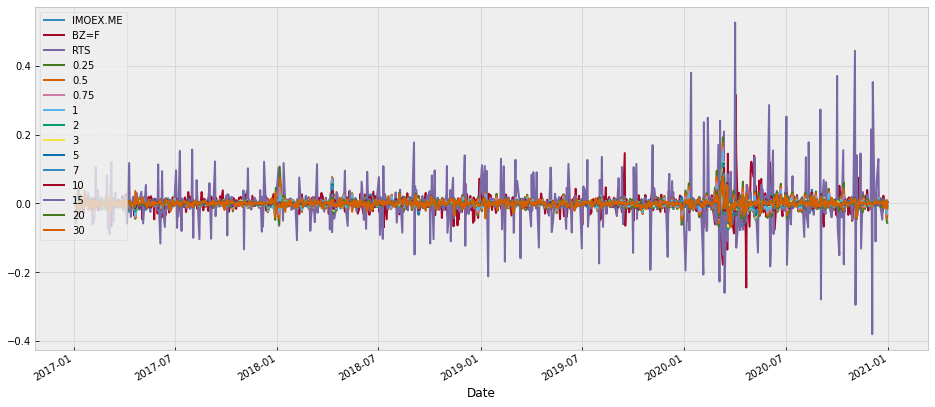

In [112]:
risk_factors_ret.plot(figsize=(16, 7))

plt.show()